## &#x1F4D1; &nbsp; Style, Links and Libraries
[`Artistic Style Transfer. Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/artistic_style_transfer.ipynb)

[`Deep Learning with R. François Chollet, J.J. Allaire`](https://github.com/jjallaire/deep-learning-with-r-notebooks)

#### Full Versions: [`Variant 1`](https://olgabelitskaya.github.io/DL_PP5_Additional.html) & [`Variant 2`](https://olgabelitskaya.github.io/DL_PP5_Additional_V2.html)

#### Language Versions: [`Python`](https://olgabelitskaya.github.io/kaggle_mixed_styles.html) & [`R`](https://olgabelitskaya.github.io/kaggle_mixed_styles_R.html)

#### Versions in Google Colaboratory: [`Variant 1`](https://colab.research.google.com/drive/1svW40BBscfSLD7Je99TyctBeRWIOYHKa) & [`Variant 2`](https://colab.research.google.com/drive/1IS_6BqJDLVbJJsuTuWTr3OfGP5uEu2eV)

In [1]:
llist<-c('IRdisplay','repr','tensorflow','keras','imager','R6')
lapply(llist,require,character.only=TRUE)
keras_backend<-backend()

Loading required package: IRdisplay
Loading required package: repr
Loading required package: tensorflow
Loading required package: keras
Loading required package: imager
Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:IRdisplay’:

    display

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image

Loading required package: R6


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [2]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>")

## Choose and Display Images

In [3]:
fpath<-"../input/image-examples-for-mixed-styles/"
original_file<-paste0(fpath,"picture03.png")
style_file<-paste0(fpath,"pattern03.png")

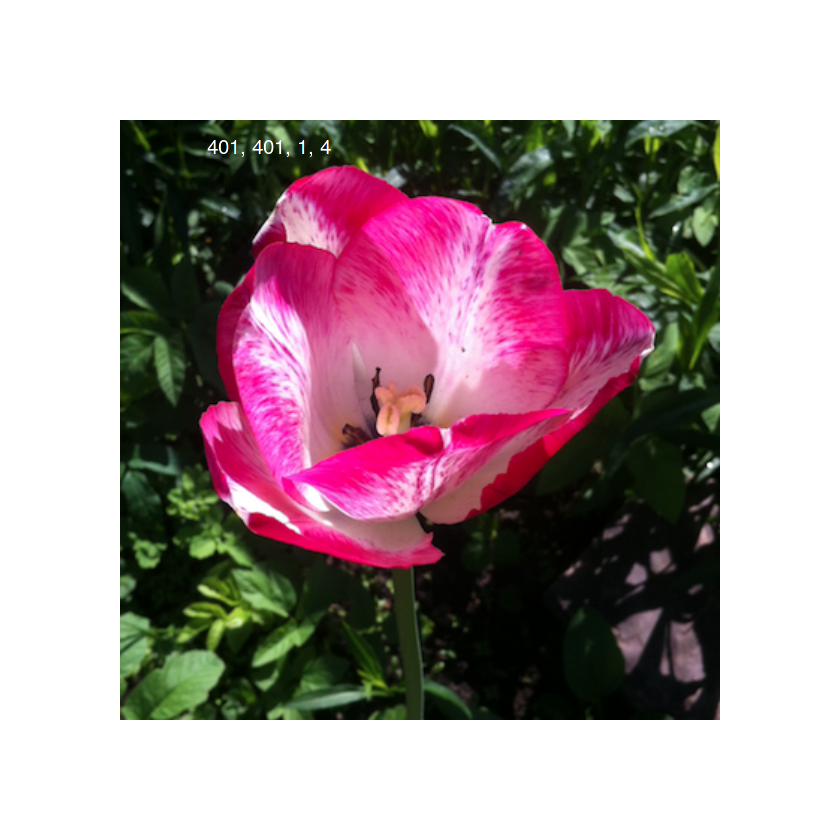

In [4]:
original<-load.image(original_file)
par(mar=c(0,0,0,0),oma=c(0,0,0,0),pin=c(5,5))
plot(original,axes=F)
text(100,20,toString(dim(original)),col='white')

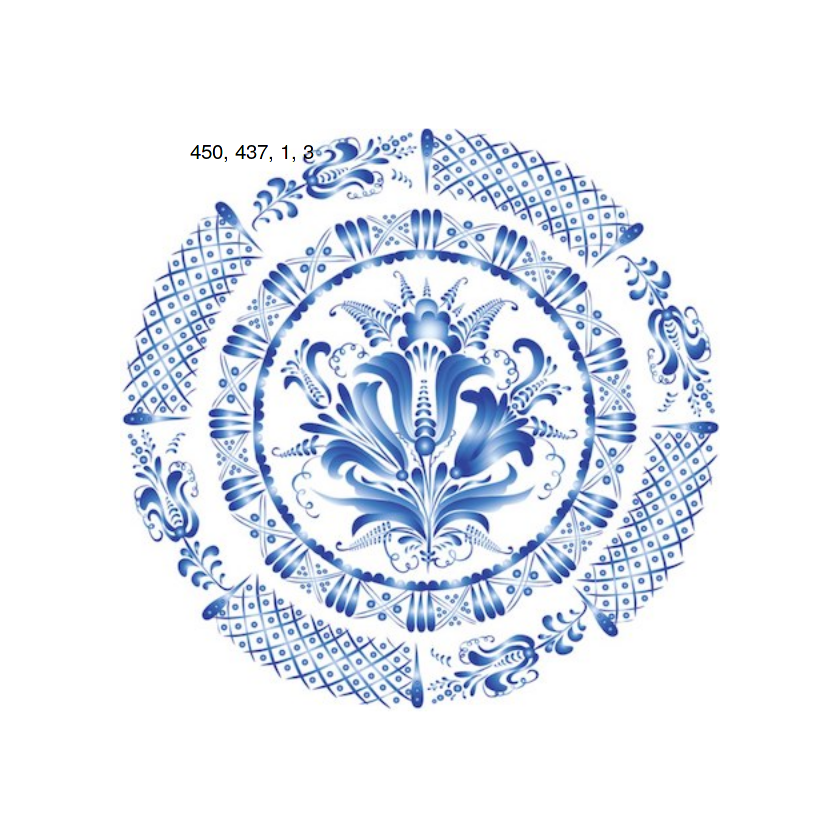

In [5]:
style<-load.image(style_file)
par(mar=c(0,0,0,0),oma=c(0,0,0,0),pin=c(5,5))
plot(style,axes=F)
text(100,20,toString(dim(style)))

## Preprocess

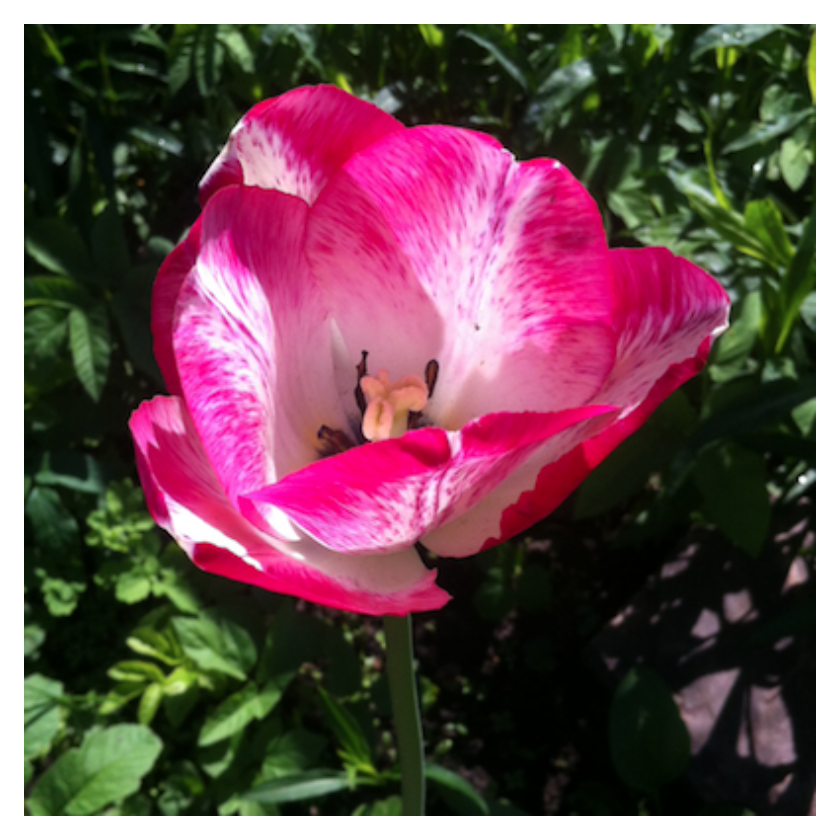

In [6]:
original_image<-image_load(original_file)
original_width<-original_image$size[[1]]
original_height<-original_image$size[[2]]
original_image_nrows<-400
original_image_ncols<-as.integer(original_width*original_image_nrows/original_height)
par(mar=c(1,1,1,1))
plot(as.raster(image_to_array(original_image)/255))

In [7]:
preprocess_image<-function(file) {
  image<-image_load(file,target_size=c(original_image_nrows,original_image_ncols))%>%
    image_to_array()%>%
    array_reshape(c(1, dim(.)))
  return(imagenet_preprocess_input(image)) }
deprocess_image<-function(x) {
  x<-x[1,,,]
  # Remove zero-center by mean pixel
  x[,,1]<-x[,,1]+103.939; x[,,2]<-x[,,2]+116.779; x[,,3]<-x[,,3]+123.68
  # bgr ⟹ rgb
  x<-x[,,c(3,2,1)]; x[x>255]<-255; x[x<0]<-0
  x[]<-as.integer(x)/255
  return(x) }

In [8]:
original_image<-keras_backend$constant(preprocess_image(original_file))
style_image<-keras_backend$constant(preprocess_image(style_file))
transfer_image<-keras_backend$placeholder(c(1L,original_image_nrows,original_image_ncols,3L)) 
input_tensor<-keras_backend$concatenate(list(original_image,style_image,transfer_image),axis=0L)

## VGG16 Usage

In [9]:
fw<-"../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
model<-application_vgg16(input_tensor=input_tensor, 
                         weight=fw,include_top=FALSE)
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, None, None, 3)           0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, None, None, 64)          1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, None, None, 64)          36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, None, None, 64)          0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, None, None, 128)         73856       
________________________________________________________________________________
block2_conv2 (Conv2D)       

In [10]:
original_loss<-function(original,transfer) {keras_backend$sum(keras_backend$square(transfer-original))}
gram_matrix<-function(x) {
  features<-keras_backend$batch_flatten(keras_backend$permute_dimensions(x,list(2L,0L,1L)))
  return(keras_backend$dot(features,keras_backend$transpose(features))) }
style_loss<-function(style,transfer) {
  channels<-3
  size<-original_image_nrows*original_image_ncols
  return(keras_backend$sum(keras_backend$square(gram_matrix(style)-gram_matrix(transfer)))/ 
         (4*channels^2*size^2)) }
variation_loss<-function(x) {
  y_ij <-x[,1:(original_image_nrows-1L),1:(original_image_ncols-1L),]
  y_i1j<-x[,2:(original_image_nrows),1:(original_image_ncols-1L),]
  y_ij1<-x[,1:(original_image_nrows-1L),2:(original_image_ncols),]
  row_diff<-keras_backend$square(y_ij-y_i1j)
  col_diff<-keras_backend$square(y_ij-y_ij1)
  return(keras_backend$sum(keras_backend$pow(row_diff+col_diff,1.25))) }

In [11]:
layers_dict<-lapply(model$layers,`[[`,"output")
names(layers_dict)<-lapply(model$layers,`[[`,"name")
original_layer<-"block5_conv2" 
style_layers<-c("block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1")
original_weight<-.5; style_weight<-1.; variation_weight<-1e-4

In [12]:
loss<-keras_backend$variable(0.0) 
layer_features<-layers_dict[[original_layer]] 
original_features<-layer_features[1,,,]
transfer_features<-layer_features[3,,,]
loss<-loss+original_loss(original_features,transfer_features)*original_weight
for (layer_name in style_layers){
  layer_features<-layers_dict[[layer_name]]
  style_features<-layer_features[2,,,]
  transfer_features<-layer_features[3,,,]
  loss<-loss+style_loss(style_features,transfer_features)*(style_weight/length(style_layers)) }
loss<-loss+variation_loss(transfer_image)*variation_weight

In [13]:
gradients<-keras_backend$gradients(loss,transfer_image)[[1]] 
fetch_loss_and_gradients<-keras_backend$`function`(list(transfer_image),list(loss,gradients))
evaluate_loss_and_gradients<-function(image) {
  image<-array_reshape(image,c(1,original_image_nrows,original_image_ncols,3))
  outputs<-fetch_loss_and_gradients(list(image))
  return(list(loss_value=outputs[[1]],
              gradient_values=array_reshape(outputs[[2]],dim=length(outputs[[2]])))) }

In [14]:
Evaluator<-R6Class("Evaluator",
  public=list(    
    loss_value=NULL,
    gradient_values=NULL,    
    initialize=function() {
      self$loss_value<-NULL
      self$gradient_values<-NULL },    
    loss=function(x) {
      loss_and_gradients<-evaluate_loss_and_gradients(x)
      self$loss_value<-loss_and_gradients$loss_value
      self$gradient_values<-loss_and_gradients$gradient_values
      self$loss_value },    
    gradients=function(x) {
      gradient_values<-self$gradient_values
      self$loss_value<-NULL
      self$gradient_values<-NULL
      gradient_values }))
evaluator<-Evaluator$new()

## Display Style Transfer

Loss: 11372654592

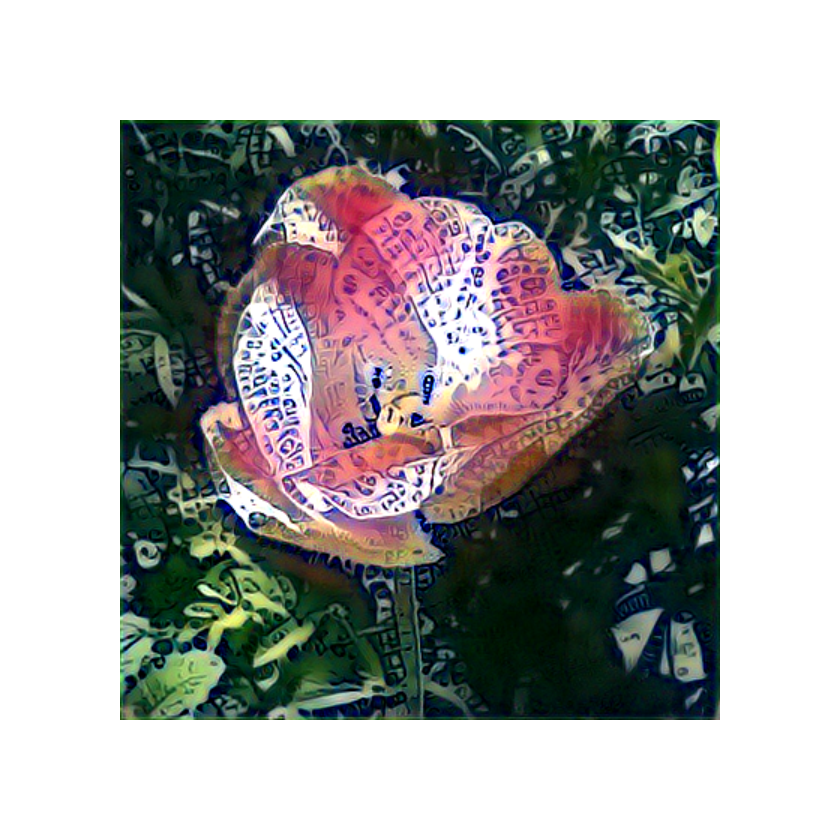

Loss: 3976493568

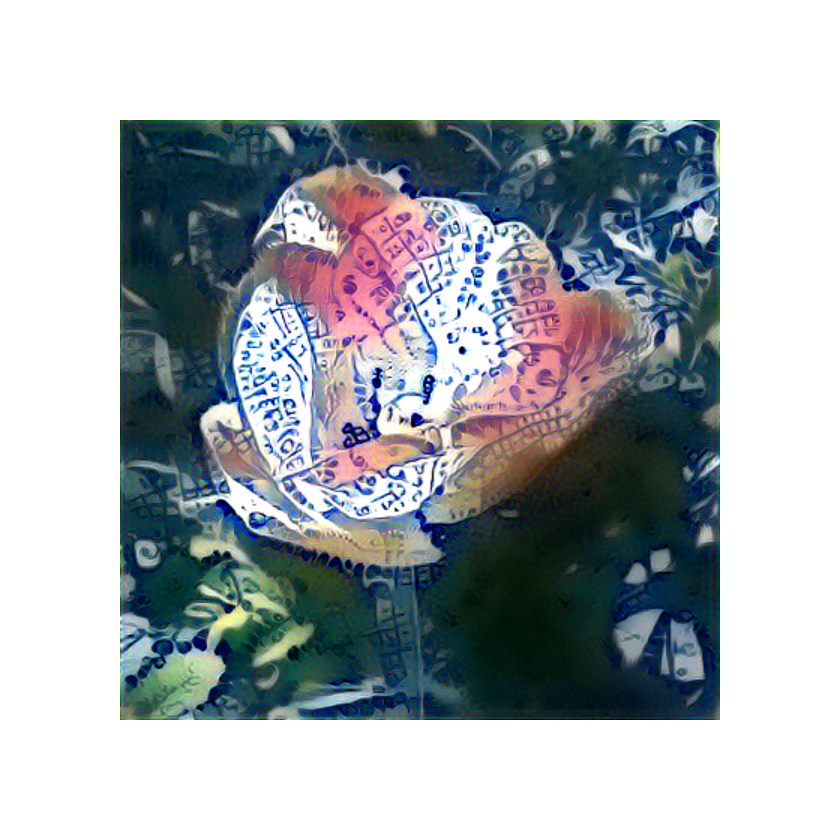

Loss: 2066912640

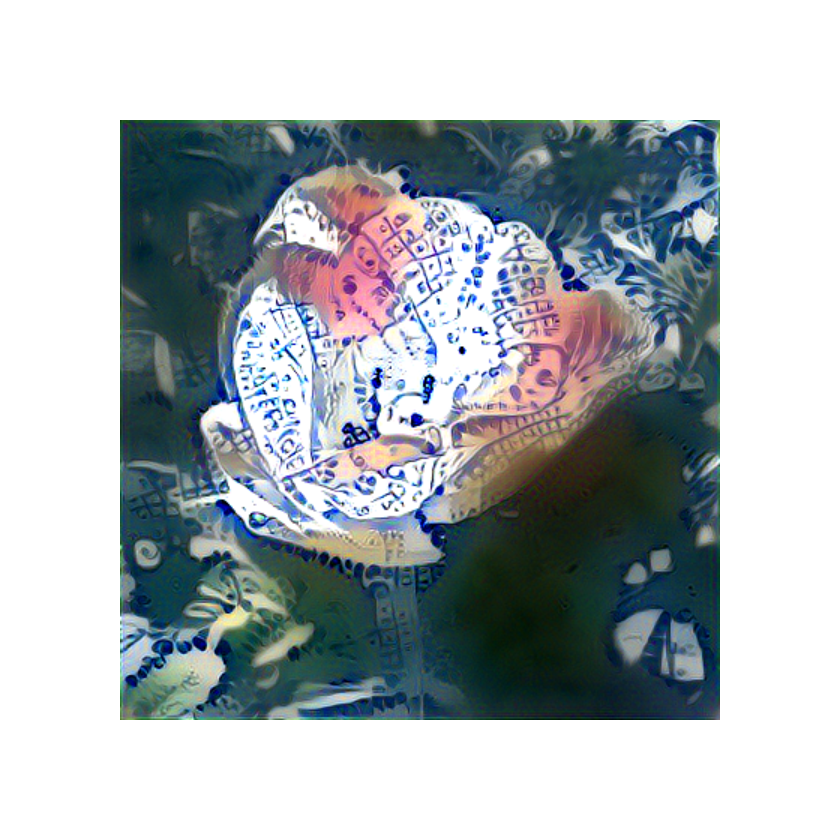

In [15]:
iterations<-6
dimensions<-c(1,original_image_nrows,original_image_ncols,3)
x<-preprocess_image(original_file)
x<-array_reshape(x,dim=length(x))
for (i in 1:iterations) { 
    opt<-optim(
        array_reshape(x,dim=length(x)), 
        fn=evaluator$loss, 
        gr=evaluator$gradients, 
        method="L-BFGS-B",
        control=list(maxit=15))  
    if (i%%2==0) {
        image<-x<-opt$par
        image<-array_reshape(image,dimensions)  
        img<-deprocess_image(image)
        par(mar=c(1,1,1,1),pin=c(5,5))
        plot(as.raster(img),main=cat("Loss:",opt$value)) } }